In [2]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import IPython
from os.path import join
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score

In [3]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
#print(true_labels)

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [5]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

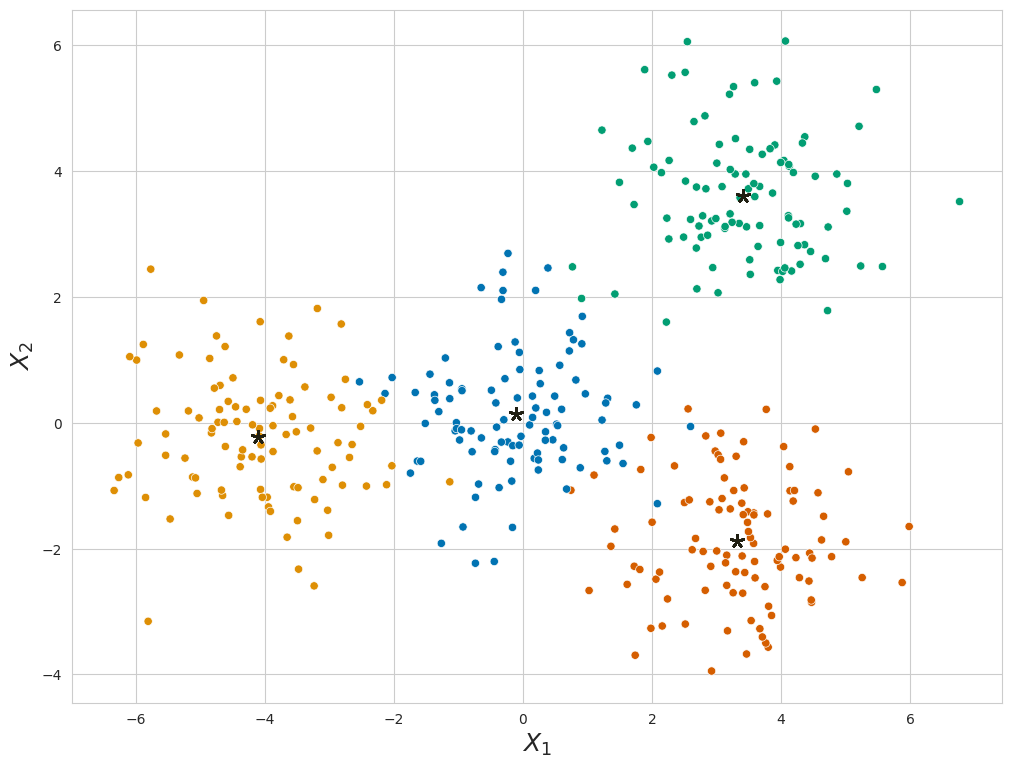

In [6]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [7]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        distances = []
        label_matrix = []
        for centroid in self.centroids:
            distances.append(self._calculate_distance(X, centroid))
        for distance in distances:
            np.append(label_matrix, distance)  

        cluster_labels = np.argmin(label_matrix, axis = 1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist= np.linalg.norm(X - centroid, axis = 1)
    
        
        return dist.reshape(X.shape[0], 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

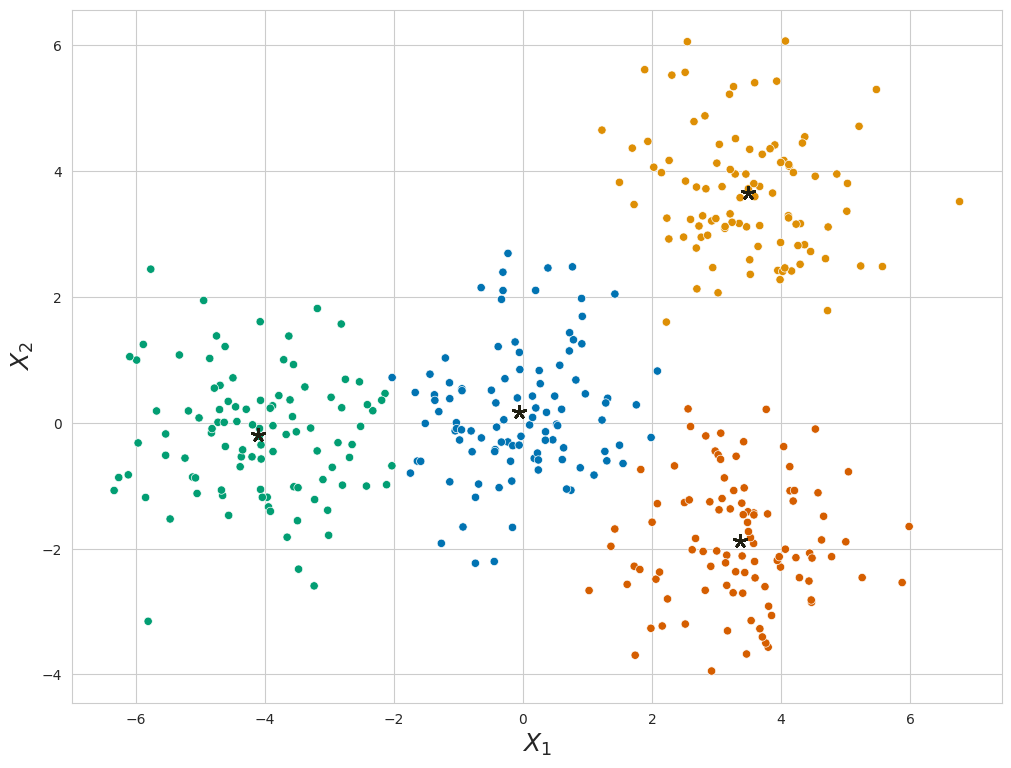

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:

my_kmean_random = MyKMeans(4, "random", 7, True)
my_kmean_sample = MyKMeans(4, "sample", 7, True)
my_kmean_random.fit(X)
my_kmean_sample.fit(X)

При обоих способах инициализации на 5-6, (до 10 точно) итерации все сводится к стабильной картинке, и координаты центроидов не меняются, я бы сказала что для таких данных эти способы одинаковы

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target
#print(y) есть все цифры от 0 до 9, 10 кластеров

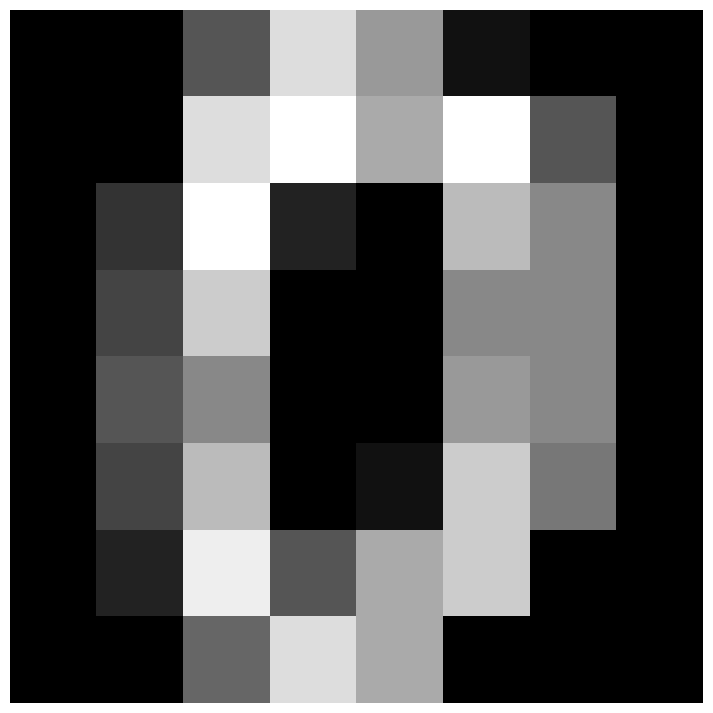

In [10]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [11]:
def algorithm_selection(X, n_clusters=10, distances = ['euclidean', 'manhattan', 'cosine', 'correlation', 'chebyshev'], algorithms =  ['average', 'single', 'complete'], metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette'] ):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        : n - число кластеров
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    results = []
  
    for distance in distances:
        for algorithm in algorithms:
            clustering = AgglomerativeClustering(n_clusters, metric = distance, linkage = algorithm)
            labels = clustering.fit_predict(X)
            row = [distance, algorithm]
            for metric in metrics:
                if metric == 'Homogeneity':
                    homogeneity = homogeneity_score(y, labels)
                    row.append(homogeneity)
                elif metric == 'Completeness':
                    completeness = completeness_score(y, labels)
                    row.append(completeness)
                elif metric == 'V-measure':
                    v_measure = v_measure_score(y, labels)
                    row.append(v_measure)
                elif metric == 'Silhouette':
                    silhouette = silhouette_score(X, labels)
                    row.append(silhouette)
            results.append(row)        

            compare_dataframe = pd.DataFrame(results, columns=['distance', 'algorithm'] + metrics)

    #best_result = results_df.loc[results_df['v_measure'].idxmax()]
    
    return compare_dataframe

In [12]:
algorithms = ['average', 'single', 'complete']
distances = ['euclidean', 'manhattan', 'cosine', 'correlation', 'canberra']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette'] 
algorithm_selection(X, 10, distances, algorithms, metrics)
 

distance algorithm  Homogeneity  Completeness  V-measure  Silhouette
0     euclidean   average     0.655393      0.782342   0.713263    0.146625
1     euclidean    single     0.005056      0.273755   0.009929   -0.133621
2     euclidean  complete     0.590549      0.637772   0.613253    0.119271
3     manhattan   average     0.566751      0.778942   0.656117    0.089217
4     manhattan    single     0.005102      0.276237   0.010019   -0.166627
5     manhattan  complete     0.646372      0.686109   0.665648    0.140183
6        cosine   average     0.648268      0.808762   0.719676    0.129526
7        cosine    single     0.005050      0.273389   0.009916   -0.158250
8        cosine  complete     0.528727      0.577415   0.551999    0.088021
9   correlation   average     0.669022      0.830525   0.741076    0.130163
10  correlation    single     0.005061      0.273992   0.009938   -0.174934
11  correlation  complete     0.554719      0.580896   0.567506    0.088853
12     canberra   average     0.573860      0.779789   0.661161    0.094335
13     canberra    single     0.006144      0.280506   0.012025   -0.181136
14     canberra  complete     0.528702      0.561588   0.544649    0.099416

Выведем лучший результат по каждой из четырех метрик

In [13]:
results = algorithm_selection(X, 10, distances, algorithms, metrics)
for i in metrics:
    print(f"best_result by {i}" )
    print(results.loc[results[i].idxmax()])



best_result by Homogeneity
distance        correlation
algorithm           average
Homogeneity        0.669022
Completeness       0.830525
V-measure          0.741076
Silhouette         0.130163
Name: 9, dtype: object
best_result by Completeness
distance        correlation
algorithm           average
Homogeneity        0.669022
Completeness       0.830525
V-measure          0.741076
Silhouette         0.130163
Name: 9, dtype: object
best_result by V-measure
distance        correlation
algorithm           average
Homogeneity        0.669022
Completeness       0.830525
V-measure          0.741076
Silhouette         0.130163
Name: 9, dtype: object
best_result by Silhouette
distance        euclidean
algorithm         average
Homogeneity      0.655393
Completeness     0.782342
V-measure        0.713263
Silhouette       0.146625
Name: 0, dtype: object


Видим, что по трем из четырех критериев лучшие показатели у алгоритма кластеризации, с праметром average и подчетом расстояния  (максимального абсолютного расстояния)

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

##### YOUR TURN TO CODE:

In [14]:
#fc_data = pd.read_csv("../Data/flow_c_data.csv")
df = pd.read_csv("../data/flow_c_data.csv", index_col=0)
print("\n  In this dataframe (Number or rows(cells), number of columns(features)) =  ", df.shape, "\n")
print('Overall number of missing values:', df.isna().sum().sum())
rows_with_na = df[df.isna().any(axis =1)]
print('Overall number of rows with missing values:', len(rows_with_na))
print('Data types:')
df.dtypes.to_frame()





  In this dataframe (Number or rows(cells), number of columns(features)) =   (10000, 9) 

Overall number of missing values: 0
Overall number of rows with missing values: 0
Data types:


0
FSC-A   float64
SSC-A   float64
HLA-DR  float64
CD3     float64
CD45    float64
CD14    float64
CD56    float64
CD19    float64
CD11c   float64

Пропущенных значений нет, приведены данные для 10000 клеток, и 9 признаков

In [15]:
df.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

number or outliers for column FSC-A = 352 

number or outliers for column SSC-A = 1030 

number or outliers for column HLA-DR = 3 

number or outliers for column CD3 = 1 

number or outliers for column CD45 = 102 

number or outliers for column CD14 = 1043 

number or outliers for column CD56 = 1226 

number or outliers for column CD19 = 2046 

number or outliers for column CD11c = 166 

Number of dublicates = 0 



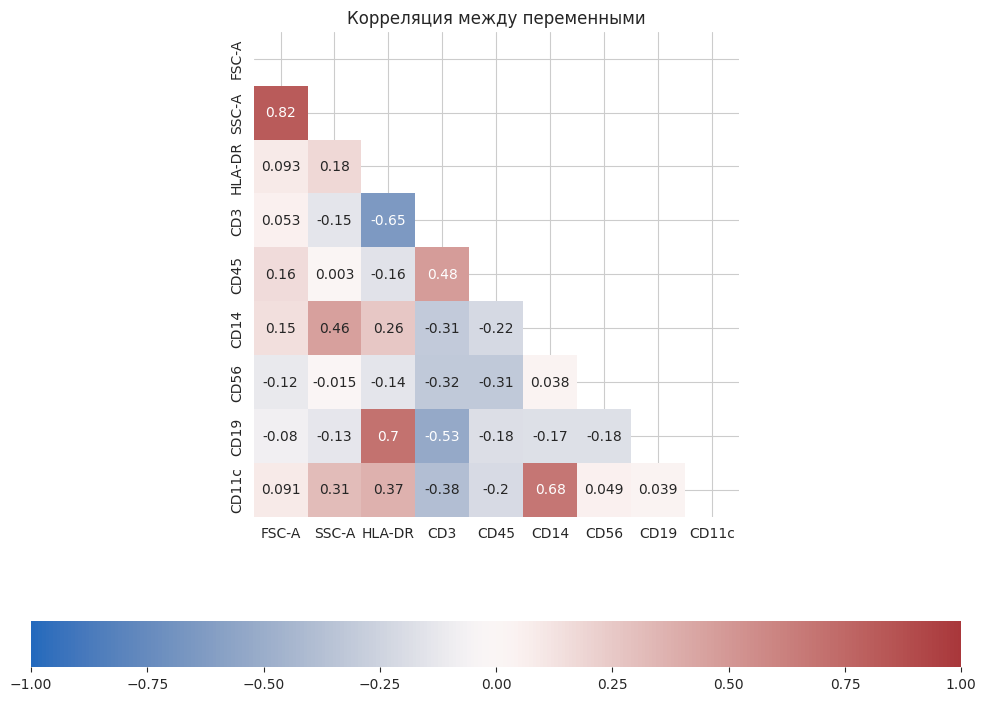

In [16]:
numeric = []
for i in range (0, df.shape[1]):
    if df.iloc[ :  , i].dtype == 'int' or df.iloc[ : ,i].dtype == 'float':
        numeric.append(df.columns[i])
for name in numeric:
    q1 = df[name].quantile(0.25)
    q3 = df[name].quantile(0.75)         
    outliers = df[(df[name] < q1 - 2*(q3-q1)) | (df[name] > q3 + 2*(q3-q1))]
    print(f"number or outliers for column {name} =", len(outliers), "\n")
#display(df.head())
#display(df.describe())
df.isnull().sum()
print('Number of dublicates =', len(df) - len(df.drop_duplicates()), "\n")  

    # создание heatplot корреляции
tr = np.triu(df.corr())
#pylab.subplot (1, 2, 2)
sns.heatmap(df.corr(), annot = True, cbar_kws= {'orientation': 'horizontal'},  vmin=-1, vmax=1, center= 0, square=True, cmap="vlag", mask = tr)
pylab.title ("Корреляция между переменными")
pylab.show()

Анализ выбросов


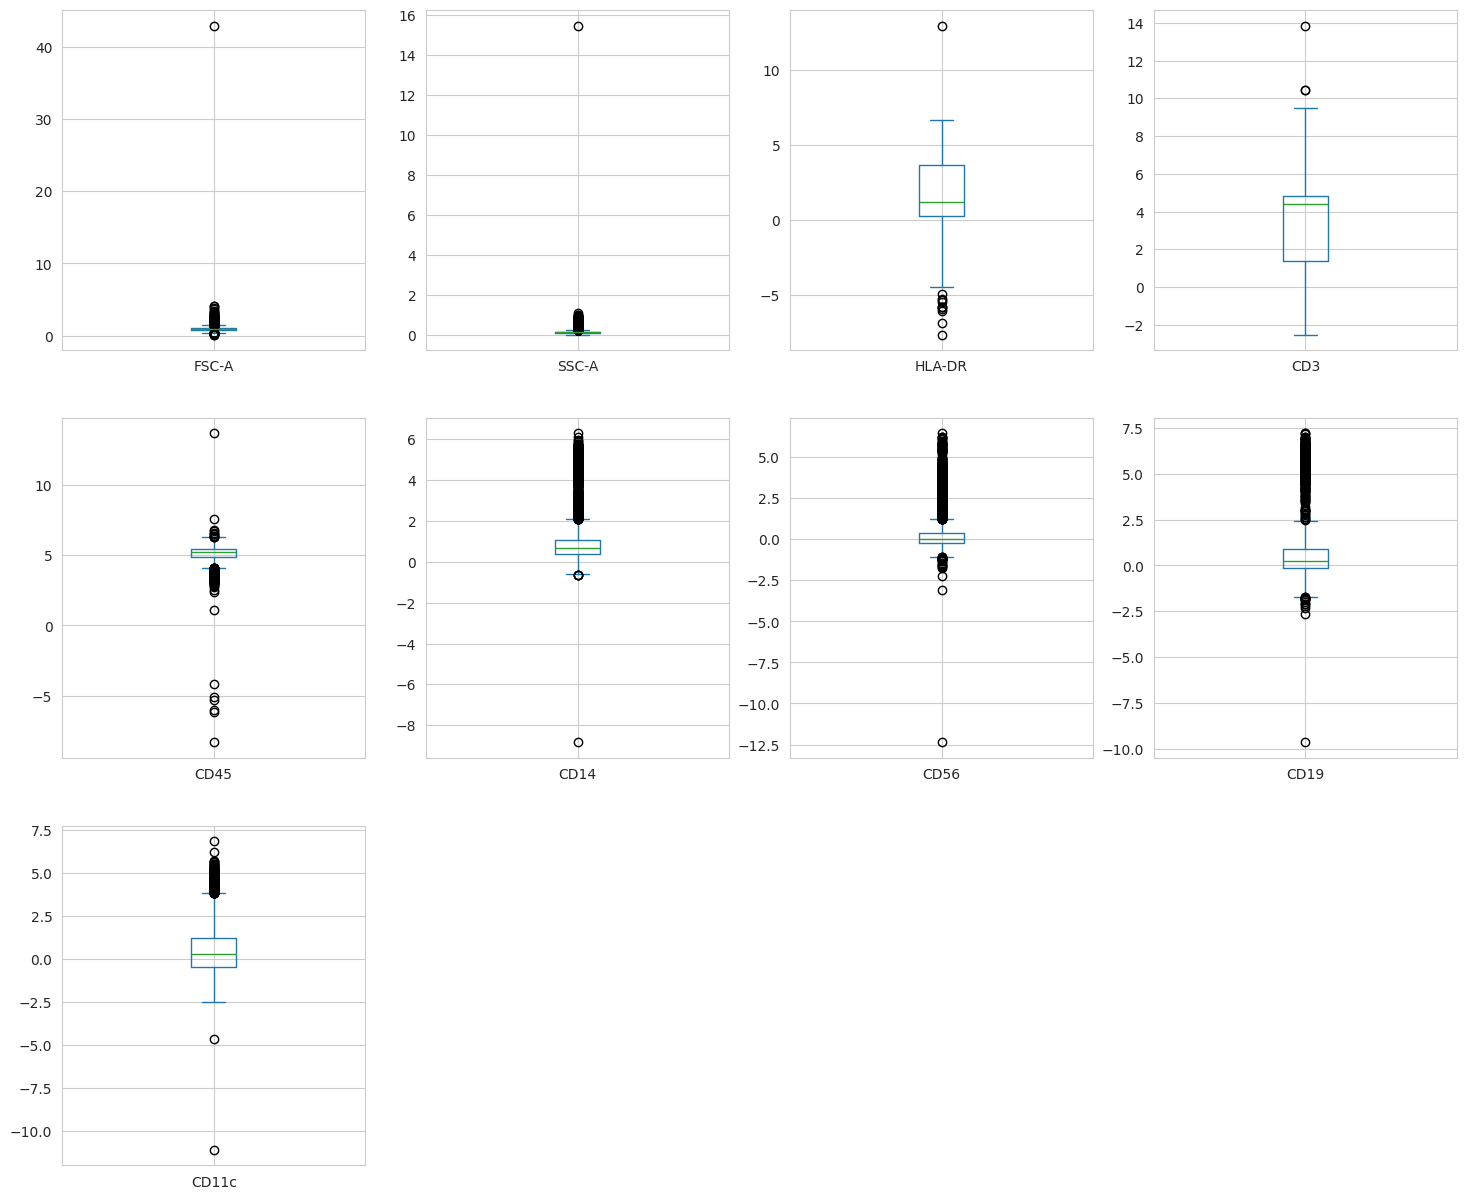

In [17]:
print('Анализ выбросов')
df.plot(kind = "box" , subplots = True , figsize = (18,15) ,  layout = (3,4))
plt.show()

Есть по всем пременным как минимум один явный выброс, проверим, возможно, это одно и то же значение, попробуем его найти и удалить

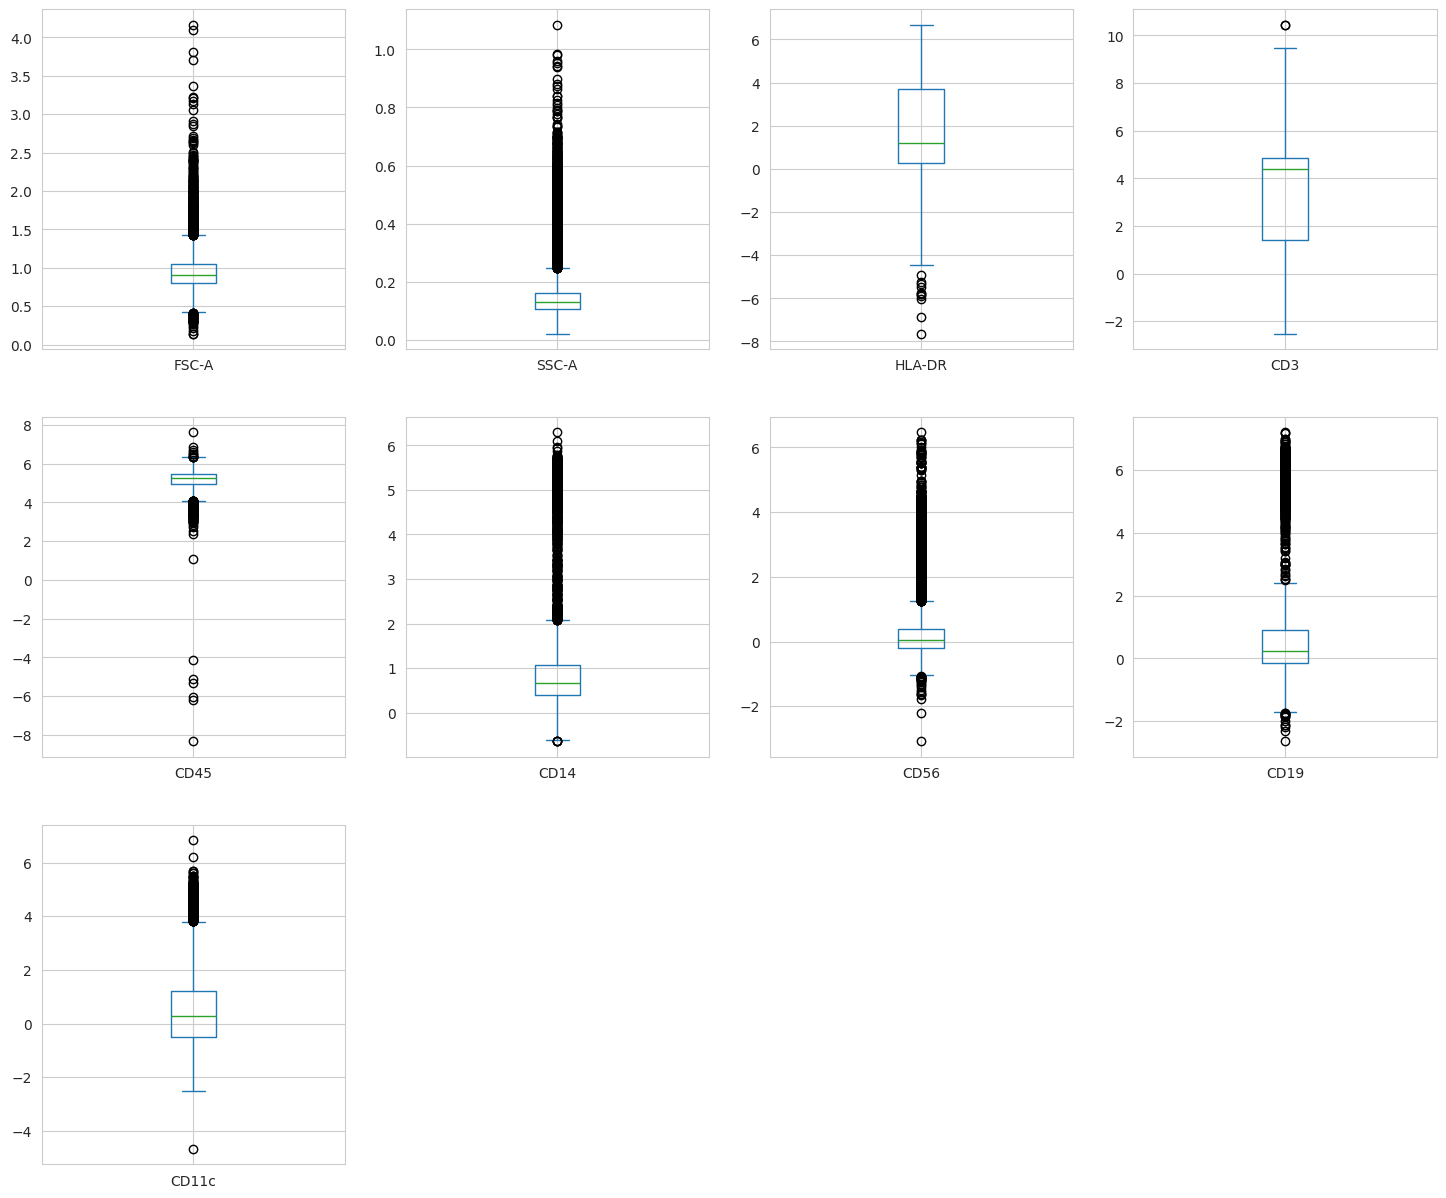

In [18]:
fc_data = df.drop(df["FSC-A"].idxmax(), inplace = False)
fc_data.plot(kind = "box" , subplots = True , figsize = (18,15) ,  layout = (3,4))
plt.show()

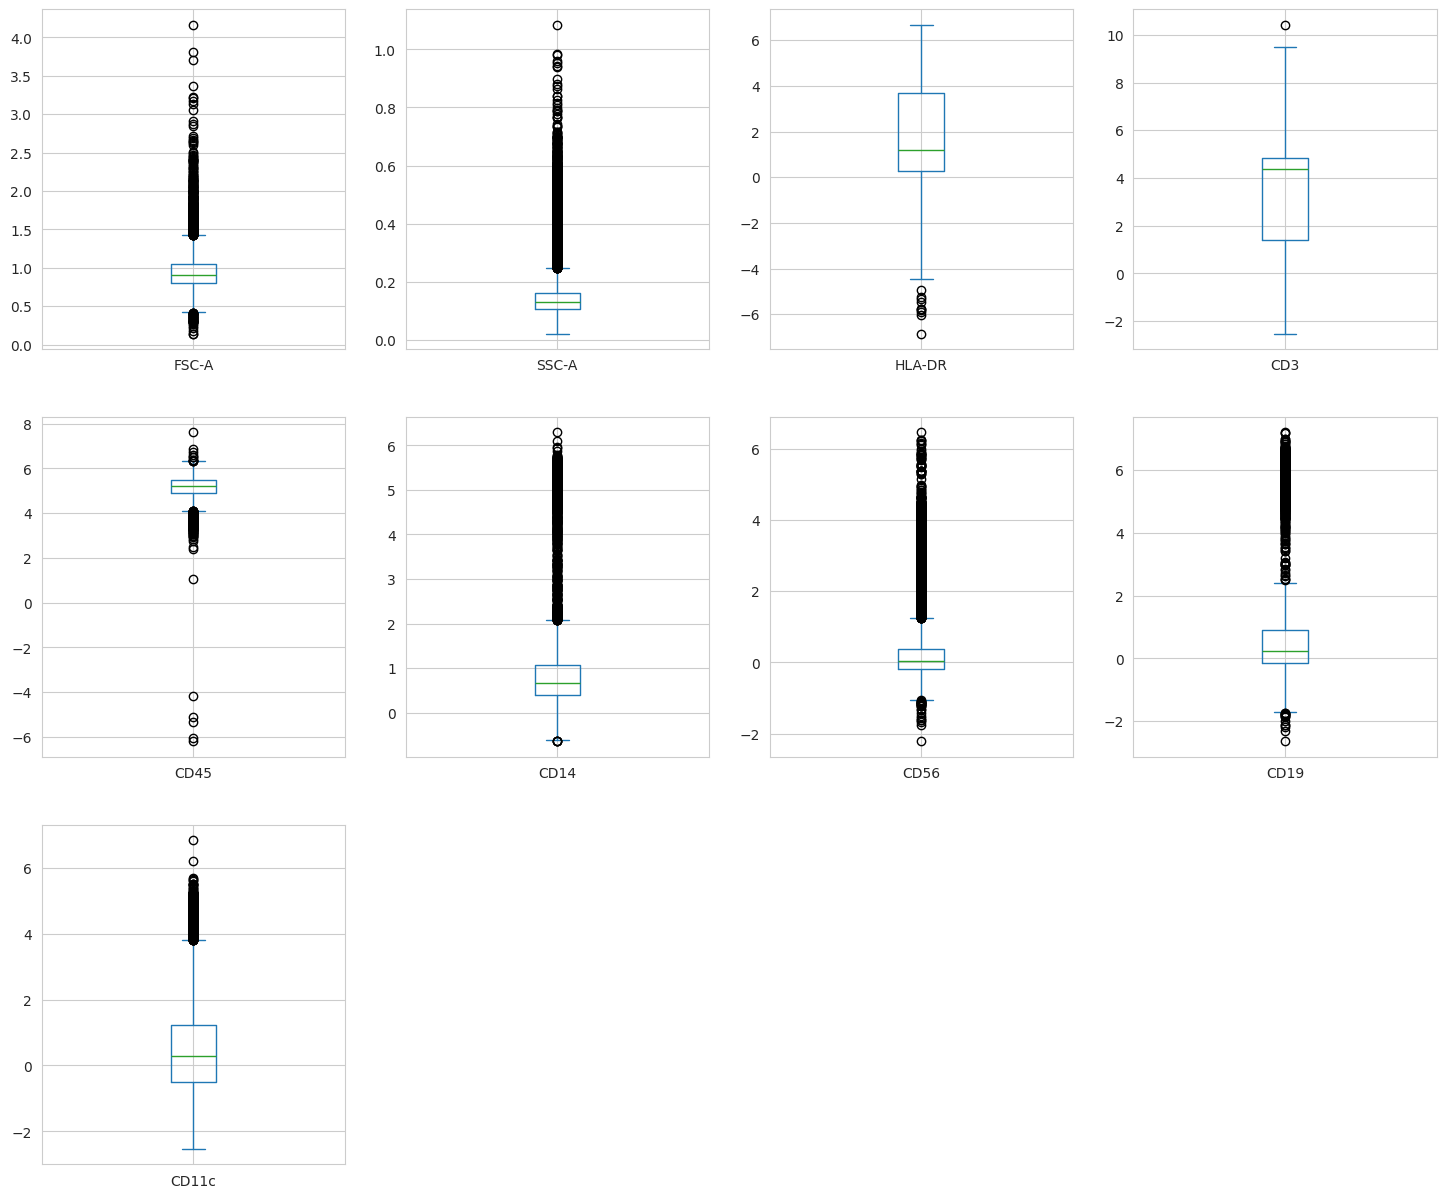

In [19]:
fc_data = fc_data.drop(fc_data["CD11c"].idxmin())
fc_data.plot(kind = "box" , subplots = True , figsize = (18,15) ,  layout = (3,4))
plt.show()

Стало лучше, еще попробовала удалить точку с минимальным значением в CD11c, слишком она одинокая, остальные "выбросы" оставим, так как их много, и не факт, что они выбросы. Данные примерно одного порядка, так что тоже нормализовать не будем. Попробую работать с тем, что есть. Update Так как я перебрала все алгоритмы и не получается примерно ничего, нормализуем данные. Update. Снормализованными так же странненько

In [20]:
scaler = StandardScaler()
fc_data = pd.DataFrame(scaler.fit_transform(fc_data), columns=fc_data.columns)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [21]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

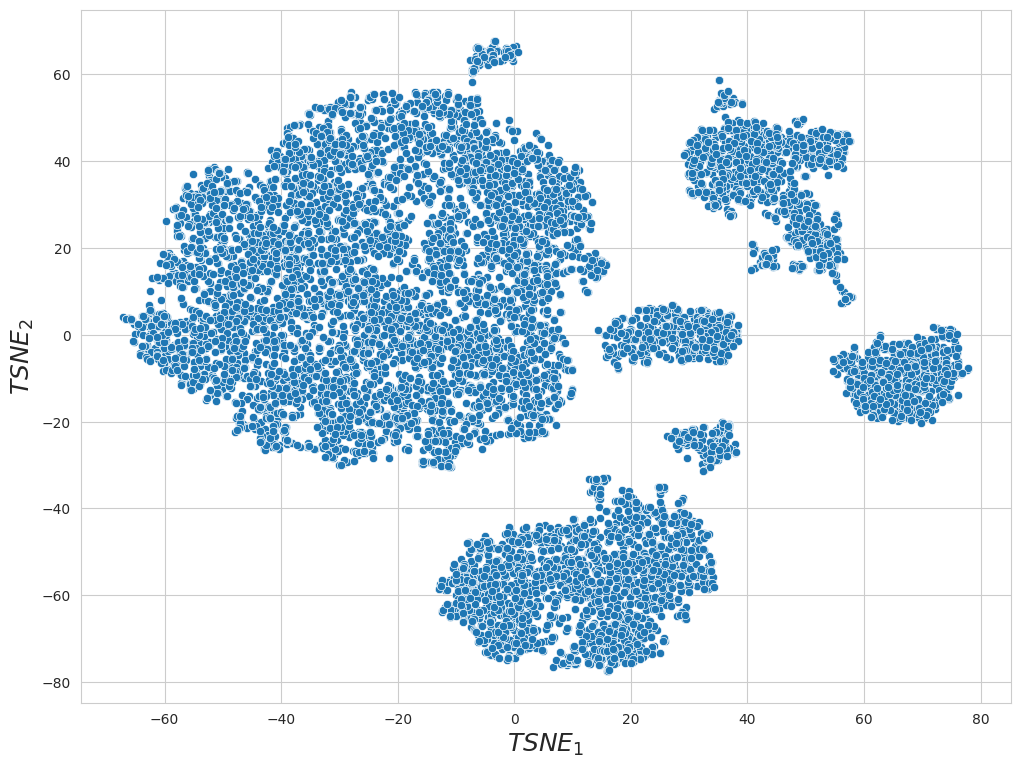

In [22]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Это очень долго работает

In [23]:

#kmean_fc = MyKMeans(4, init="random", max_iter=10, visualize=True)
#kmean_fc.fit(tsne_res)
#kmean_fc_pred = kmean_fc.predict(tsne_res)
#silhouette_score(fc_data, kmean_fc_pred)

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Нет, считает очень долго и очень не очень. Попробуем готовую KMeans, я пробовала с разыми параметрами и числом кластеров (4,5, 6), оставляю один вариант, как будет лучше дял дальнейшей задачи

array([[ 76.01067509,  -6.41330441],
       [ 11.05410476, -53.76350655],
       [-56.84306332,  31.4058005 ],
       ...,
       [ 52.3717864 ,  16.13241666],
       [ 68.83147428, -12.45410525],
       [ 68.69423321,  -7.19204945]])

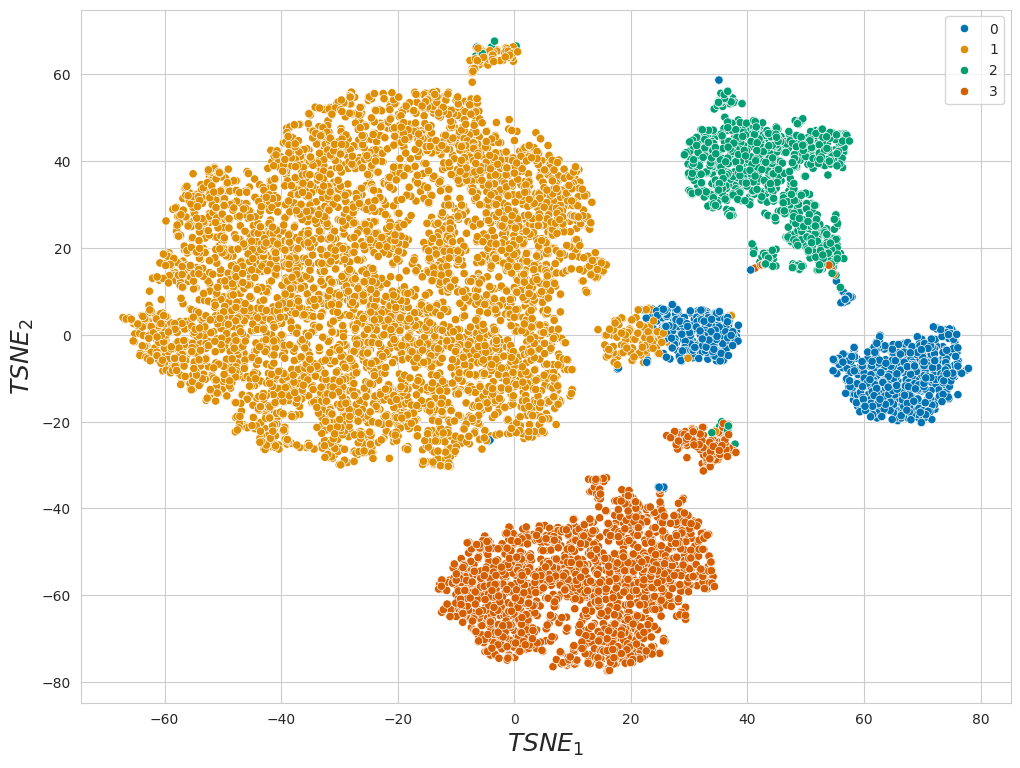

In [24]:
kmeans = KMeans(n_clusters = 4, algorithm= 'elkan')
kmeans.fit(fc_data)
#cluster_centers = kmeans.cluster_centers_
plot_tsne(fc_data, color= kmeans.labels_)


Попробуем другой алгоритм аггломеративный

In [ ]:
cell_types_clust_scores_ac = algorithm_selection(fc_data, n_clusters =4, distances = ['euclidean', 'manhattan', 'cosine', 'correlation', 'chebyshev', 'jaccard', 'canberra'],  metrics=['Silhouette'])
#distances = ['cosine', 'jaccard', 'russellrao', 'canberra', 'sokalmichener', 'chebyshev', 'sqeuclidean', 'seuclidean', 'yule', 'matching', 'correlation', 'dice', 'euclidean', 'braycurtis', 'cityblock', 'minkowski', 'wminkowski', 'sokalsneath', 'rogerstanimoto', 'manhattan', 'hamming']


: 

Оцените степень моего отчаяния, у меня упорно все делилось на 3 группы + точка и я решила пробовать ВСЕ

In [ ]:
cell_types_clust_scores_ac

distance algorithm  Silhouette
0     euclidean   average    0.585570
1     euclidean    single    0.575817
2     euclidean  complete    0.431971
3     manhattan   average    0.560331
4     manhattan    single    0.583829
5     manhattan  complete    0.470232
6        cosine   average    0.484445
7        cosine    single   -0.351409
8        cosine  complete    0.155365
9   correlation   average    0.486437
10  correlation    single   -0.355241
11  correlation  complete    0.113550
12    chebyshev   average    0.532642
13    chebyshev    single    0.575817
14    chebyshev  complete    0.360762
15      jaccard   average    0.014673
16      jaccard    single    0.014673
17      jaccard  complete    0.014673
18   russellrao   average    0.014673
19   russellrao    single    0.014673
20   russellrao  complete    0.014673
21     canberra   average    0.471743
22     canberra    single   -0.260554
23     canberra  complete    0.252552

0.5758170177979756


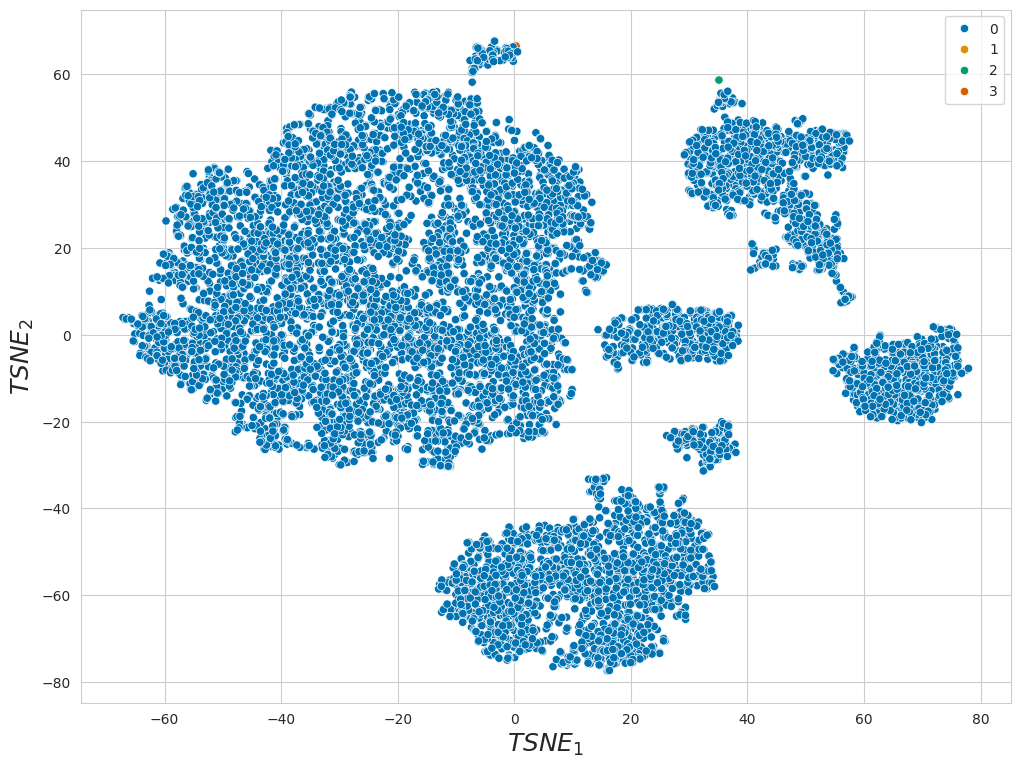

In [ ]:
ag_fc = AgglomerativeClustering(4, metric ='euclidean', linkage='single')
predicted = ag_fc.fit_predict(fc_data)
print(silhouette_score(fc_data, predicted))
#plt.figure(figsize=(6,5))
tsne_res_ag = plot_tsne(fc_data, color=predicted)

Вообще не очень, попробуем другие параметры


0.5758170177979756


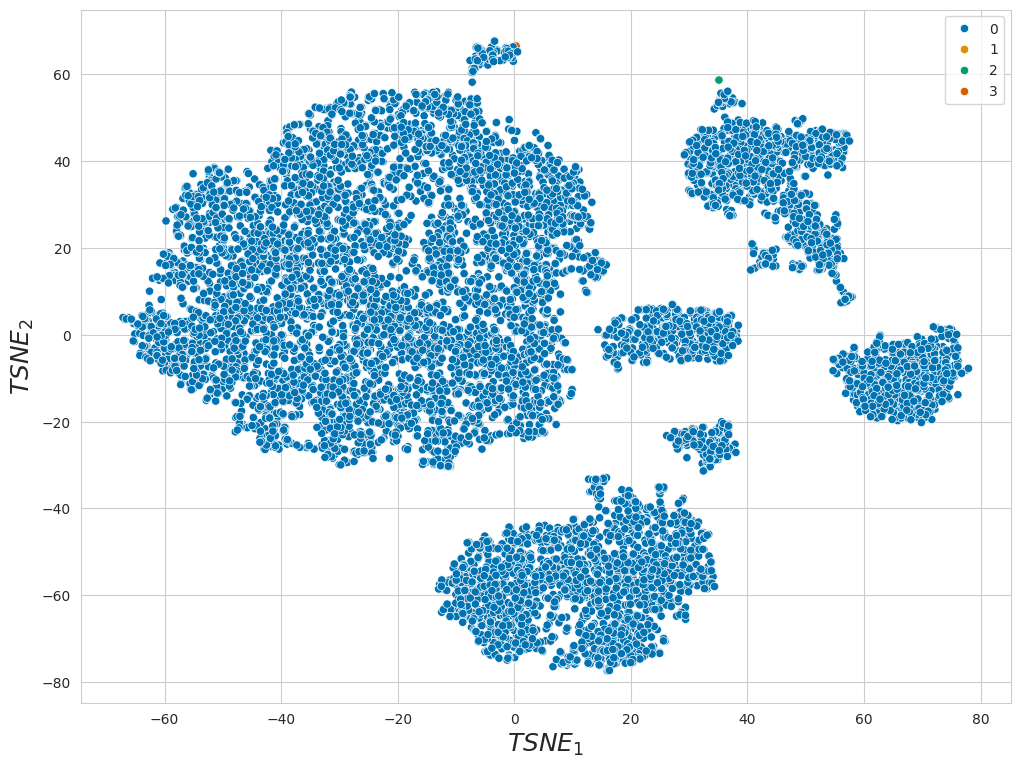

In [ ]:
ag_fc = AgglomerativeClustering(4, metric = 'chebyshev', linkage='single')
predicted = ag_fc.fit_predict(fc_data)
print(silhouette_score(fc_data, predicted))
#plt.figure(figsize=(6,5))
tsne_res_ag = plot_tsne(fc_data, color=predicted)

0.48444469053321304


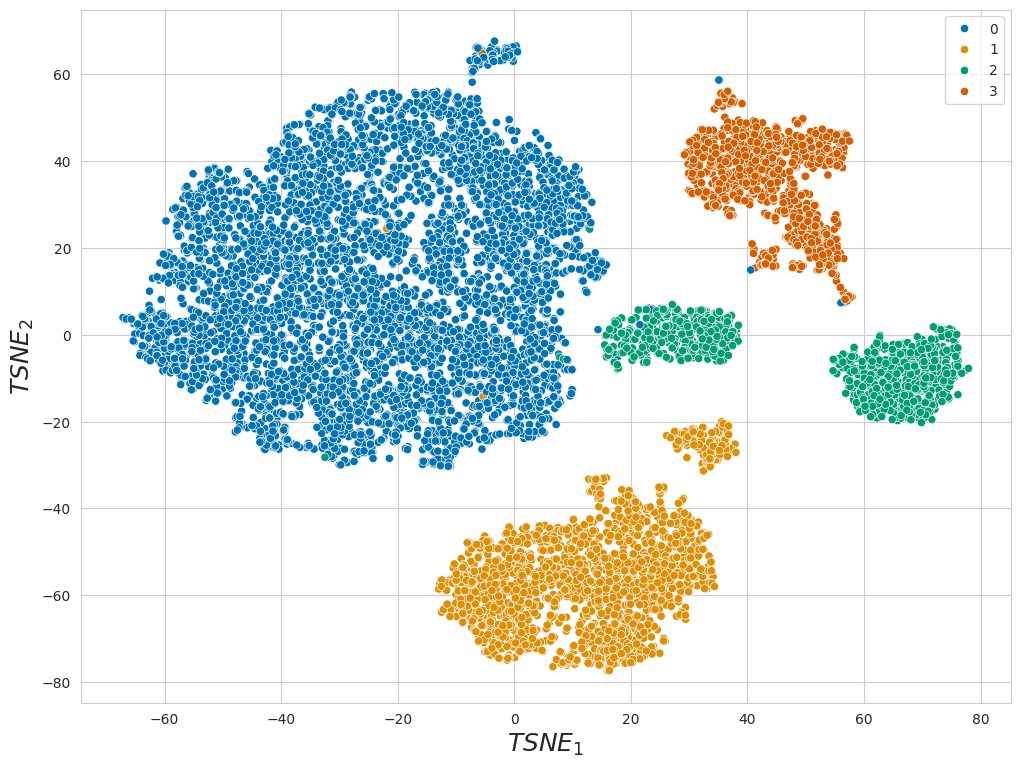

In [ ]:
ag_fc = AgglomerativeClustering(4, metric = 'cosine', linkage='average')
predicted = ag_fc.fit_predict(fc_data)
print(silhouette_score(fc_data, predicted))
#plt.figure(figsize=(6,5))
tsne_res_ag = plot_tsne(fc_data, color=predicted)

И тут, поверьте мне на слово я перепробовала очень много комбинаций. Вот это самое приемлимое

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

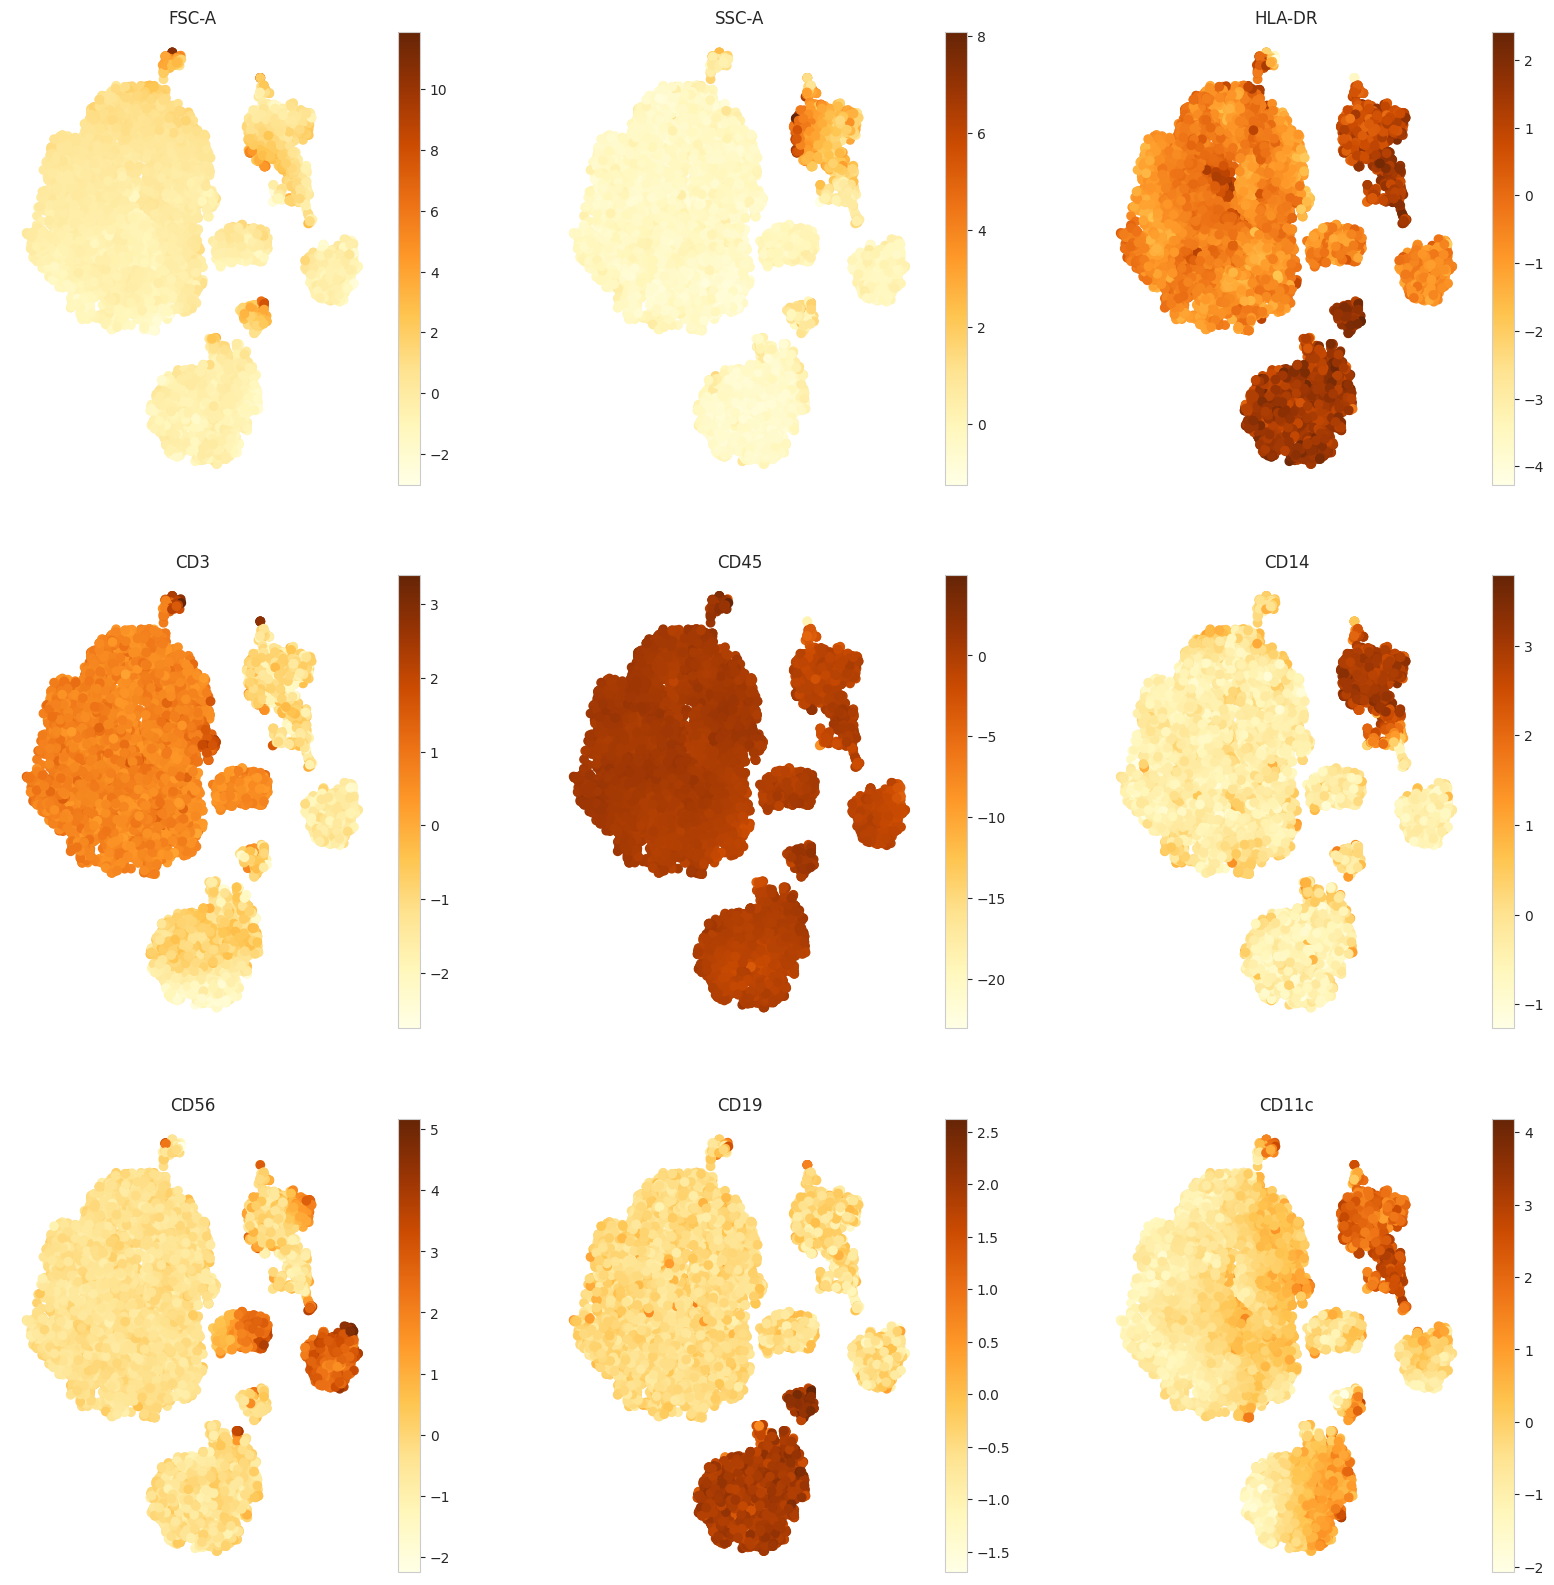

In [ ]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

подпишем какие маркеры где больше экспрессированны

используем последнюю модель ag_fc

In [ ]:
cell_type_cluster_map = {0: "T-cells", # CD3
                         1: "B-cells", # CD19
                         2: "Other cells", # CD56
                         3: "Monocytes"} # CD14

In [ ]:
labeled_fc_data = fc_data.assign(Population=ag_fc.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [ ]:
labeled_fc_data["Population"].value_counts()

Population
T-cells        5771
B-cells        2038
Monocytes      1100
Other cells    1089
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Не думаю, что этой весной, но обязательно доеду до Гренландии!

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**